<a href="https://colab.research.google.com/github/hsallrounder/Pattern-And-Anomaly-Detection-Lab/blob/main/cnn_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 style='color:blue' align='center'>Transfer learning in image classification</h2>

**In this notebook we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand**

In [1]:
# Install tensorflow_hub using pip install tensorflow_hub first

In [2]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Make predictions using ready made model (without any training)**

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


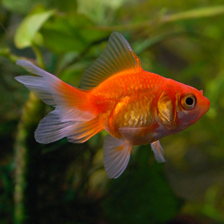

In [5]:
gold_fish = Image.open("/content/drive/MyDrive/Datasets/goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [6]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [7]:
gold_fish[np.newaxis, ...].shape

(1, 224, 224, 3)

In [8]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

1/1 [==============================] - 2s 2s/step


(1, 1001)

In [9]:
result

array([[ 0.22101453,  2.0474904 ,  9.622561  , ..., -1.4621578 ,
        -0.28146464, -0.2598482 ]], dtype=float32)

In [10]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [11]:
label_dir = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
label_dir

'/root/.keras/datasets/ImageNetLabels.txt'

In [12]:
image_labels = []
with open(label_dir, "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [13]:
image_labels[predicted_label_index]

'goldfish'

<h3 style='color:purple'>Load flowers dataset</h3>

In [14]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

In [15]:
data_dir

'./datasets/flower_photos'

In [16]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [17]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/daisy/9161647994_e39b65cb9c_n.jpg'),
 PosixPath('datasets/flower_photos/daisy/16121105382_b96251e506_m.jpg'),
 PosixPath('datasets/flower_photos/daisy/15029936576_8d6f96c72c_n.jpg'),
 PosixPath('datasets/flower_photos/daisy/14866200659_6462c723cb_m.jpg'),
 PosixPath('datasets/flower_photos/daisy/13491959645_2cd9df44d6_n.jpg')]

In [18]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [19]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/353897245_5453f35a8e.jpg'),
 PosixPath('datasets/flower_photos/roses/2535466143_5823e48b63.jpg'),
 PosixPath('datasets/flower_photos/roses/2980099495_cf272e90ca_m.jpg'),
 PosixPath('datasets/flower_photos/roses/685724528_6cd5cbe203.jpg'),
 PosixPath('datasets/flower_photos/roses/16258946661_f9739cdc0a.jpg')]

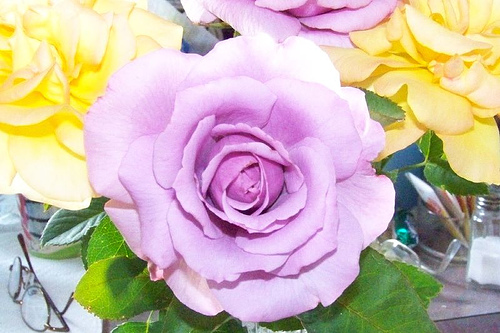

In [20]:
Image.open(str(roses[3]))

In [21]:
tulips = list(data_dir.glob('tulips/*'))
tulips[:5]

[PosixPath('datasets/flower_photos/tulips/5674707464_dc18de05b1.jpg'),
 PosixPath('datasets/flower_photos/tulips/14836105101_1d07520932_m.jpg'),
 PosixPath('datasets/flower_photos/tulips/14087439392_969444f56e.jpg'),
 PosixPath('datasets/flower_photos/tulips/7205145492_baec4dbb94.jpg'),
 PosixPath('datasets/flower_photos/tulips/6808860548_53796b90ca_n.jpg')]

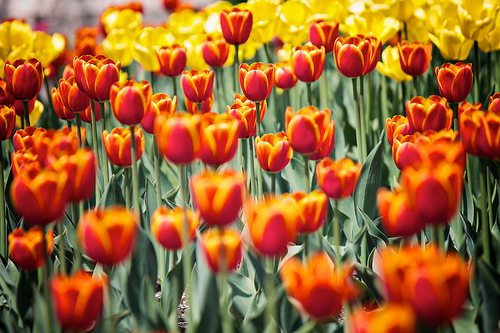

In [22]:
Image.open(str(tulips[3]))

<h3 style='color:purple'>Read flowers images from disk into numpy array using opencv</h3>

In [23]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [24]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/353897245_5453f35a8e.jpg'),
 PosixPath('datasets/flower_photos/roses/2535466143_5823e48b63.jpg'),
 PosixPath('datasets/flower_photos/roses/2980099495_cf272e90ca_m.jpg'),
 PosixPath('datasets/flower_photos/roses/685724528_6cd5cbe203.jpg'),
 PosixPath('datasets/flower_photos/roses/16258946661_f9739cdc0a.jpg')]

In [25]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [26]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/353897245_5453f35a8e.jpg'

In [27]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [28]:
img.shape

(375, 500, 3)

In [29]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [30]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,IMAGE_SHAPE)
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [31]:
X = np.array(X)
y = np.array(y)

<h3 style='color:purple'>Train test split</h3>

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<h3 style='color:purple'>Preprocessing: scale images</h3>

In [33]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Make prediction using pre-trained model on new flowers dataset**

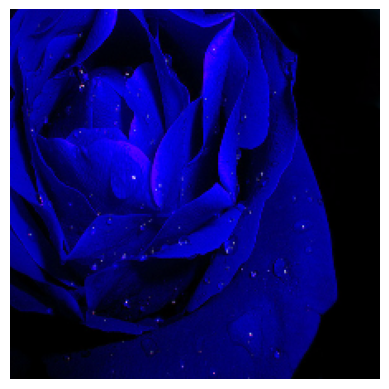

In [34]:
plt.axis('off')
plt.imshow(X[0])

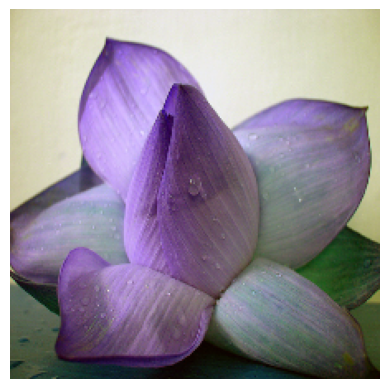

In [35]:
plt.axis('off')
plt.imshow(X[1])

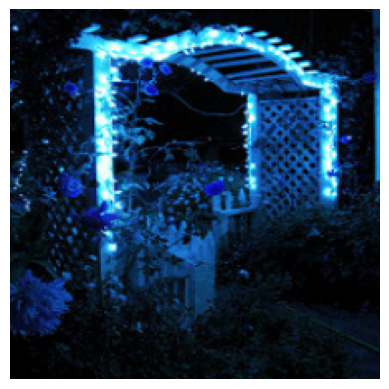

In [36]:
plt.axis('off')
plt.imshow(X[2])

In [37]:
predicted = classifier.predict(np.array([X[0],X[1],X[2]]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 1s 653ms/step


array([550, 722, 795])

In [38]:
image_labels[795]

'shower curtain'

<h3 style='color:purple'>Now take pre-trained model and retrain it using flowers images</h3>

In [39]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [40]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [41]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=1)

86/86 [==============================] - 105s 1s/step - loss: 0.8526 - acc: 0.6839


In [42]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 43s 1s/step - loss: 0.5165 - acc: 0.8007


[0.5164703130722046, 0.8006535768508911]